# Analysis of GDP Damage Functions

#### Independent Variables : Temperature, Precipitation and Sea Level Change
#### Dependent Variable: GDP Growth Rate

In [21]:
import pandas as pd
pd.set_option('display.precision', 4)
pd.set_option('display.max_rows', 99999)
import numpy as np
import statsmodels.api as sm
from matplotlib import pyplot as plt
import os
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller as adf
from sklearn.metrics import r2_score
from sklearn import metrics
import math
import sklearn
import itertools
from statsmodels.stats.outliers_influence import variance_inflation_factor
#os.chdir(os.getcwd()[:-7] + '1. Input/2. Processed Data')
os.getcwd()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/yuqingwu/OneDrive - The University of Chicago/Winter 2022/WinterCodes/1. Input/2. Processed Data'

### Data Transformation for dependent variables
    1. Raw Data
    2. Percentage change
    3. First difference
    4. Second difference

### Data Transformation for independent variables
    1. Raw Data
    2. First difference
    3. Second difference
    4. Raw*First difference
    5. Raw*Second difference 
    
    Based on all the data transformation we have above, we do squared and cube of them so we have 3*5 = 15 columns
    
    Again, we do lag 0.1.2 of the transformation we have. Then num of columns in the output dataframe is 15*3 = 45 columns. Lag1 implies today's GDP on yesterday's temperature. Lag2 implies today's GDP on temperature the day before yesterday.

In [2]:
'''
Data Transformation Functions:

1. These functions help create all the transformations required and store these in a dataframe for processing later
2. They are also used to transform the frequency (quarterly or annual)
3. if variable name is passed then a Data file is read from the base directory, otherwise a dataframe must be passed in df

'''

def build_dependent_df(variable, yearly=False, transform = 'Percent Change', df = None):
    if df is None:
        df = pd.read_excel(variable+".xls")
        df.iloc[:, 0] = pd.to_datetime(df.iloc[:, 0],format='%Y-%m-%d')
        df.iloc[:, 0] = pd.to_datetime(df.iloc[:, 0]).dt.to_period('Q')
        df.columns = ['Date', variable]
        df = df.set_index('Date')
        if yearly:
            df = df.resample('Y').mean()
    new_df = pd.DataFrame(index = df.index)
    org_name = df.columns[0]
    if transform == 'Raw':
        new_df[org_name] = df[org_name]
    if transform == 'Percent Change':
        name = '% chg ' + org_name
        new_df[name] = df[org_name].pct_change()
    if transform == 'Delta':
        name = r' $\Delta$' + org_name
        new_df[name] = df[org_name].diff()
    if transform == 'Delta Square':
        name = r' $\Delta^2$' + org_name
        new_df[name] = df[org_name].diff().diff()
    return new_df


def build_independent_df(variable,yearly=False, df = None):
    if df is None:
        df = pd.read_csv(variable+'.csv', skiprows = 4)
        df['Date'] = pd.to_datetime(df['Date'],format='%Y%m')
        df['Date'] = pd.to_datetime(df['Date']).dt.to_period('M')
        df = df.drop(['Anomaly'], axis=1)
        df = df.set_index('Date')
        if yearly:
            df = df.resample('Y').mean()
        else:
            df = df.resample('Q').mean()
        
    df = df.rename(columns={"Value": variable})

    ########### Add log transformation ##############
    df[r'log'+variable] = np.log(df[variable])
    ########### Add exponential transformation ##############
    df[r'exp'+variable] = np.exp(df[variable])

    df[r' % change'+variable] = df[variable].pct_change()
    df[r'$\Delta$'+variable] = df[variable].diff()
    df[r'$\Delta^2$'+variable] = df[r'$\Delta$'+variable].diff()
    df[variable+r'*($\Delta)$'] = df[variable]*df[r'$\Delta$'+variable]
    df[variable+r'*($\Delta^2)$'] = df[variable]*df[r'$\Delta^2$'+variable]

    df_sqr = df**2
    col_names = df.columns
    for name in col_names:
        df_sqr = df_sqr.rename(columns={name:name+r'^2'})

    df_cube = df**3
    col_names = df.columns
    for name in col_names:
        df_cube = df_cube.rename(columns={name:name+r'^3'})
    df = pd.concat([df,df_sqr,df_cube], axis = 1)

    df_lag1 = df.shift()
    col_names = df.columns
    for name in col_names:
        df_lag1 = df_lag1.rename(columns={name:name+' lag1'})

    df_lag2 = df.shift(2)
    col_names = df.columns
    for name in col_names:
        df_lag2 = df_lag2.rename(columns={name:name+' lag2'})

    df = pd.concat([df,df_lag1,df_lag2], axis = 1)


    return df

In [3]:
'''
Regression Analysis Functions:

1. These functions run all possible regressions between the dependent variable and the independent variables
2. Single Regression only consider one variable in the regression
3. Multi-Regression considers a group of variables against the dependent variable in the regression

'''

def single_regression(dependent, independent, end = '2020', dummy=False):
    dependent = dependent.loc[:end]
    independent = independent.loc[:end]
    summary = pd.DataFrame(columns = ['R_squared', 'beta', 'p_value'])
    
    for dep in dependent.columns:
        lhs = dependent[dep]
        for indep in independent.columns:
            rhs = sm.add_constant(independent.loc[lhs.index, indep])
            if dummy:
                rhs['season'] = rhs.index
                rhs['season'] = rhs.index
                rhs['season'] = rhs['season'].astype(str)
                rhs['season'] = rhs['season'].str[-1:]
                dummies = pd.get_dummies(rhs['season'])
                rhs = pd.concat([rhs, dummies], axis = 1)
                rhs = rhs.drop(['season'], axis=1)
            res = sm.OLS(lhs, rhs, missing='drop').fit()
            R_squared = round(res.rsquared, 4)
            beta = round(res.params[1], 4)
            p_value = round(res.pvalues[1], 4)
            lhs_predict = res.predict(rhs)

            if len(lhs.dropna()) <= len(lhs_predict.dropna()):
                start_time = lhs.dropna().index[0]
                end_time = lhs.dropna().index[-1]
                lhs_predict = lhs_predict[str(start_time):str(end_time)] 
                mse = sklearn.metrics.mean_squared_error(lhs.dropna(), lhs_predict)
            else:
                start_time = lhs_predict.dropna().index[0]
                end_time = lhs_predict.dropna().index[-1]
                lhs_predict = lhs_predict[str(start_time):str(end_time)]  
                lhs_mse = lhs.dropna()[str(start_time):str(end_time)]
                mse = sklearn.metrics.mean_squared_error(lhs_mse, lhs_predict)
            
            summary.loc[dep + '_' + indep, 'R_squared'] = R_squared
            summary.loc[dep + '_' + indep, 'beta'] = beta
            summary.loc[dep + '_' + indep, 'p_value'] = p_value
            summary.loc[dep + '_' + indep, 'RMSE'] = math.sqrt(mse)
    
    return summary

def multi_regression(dependent, independent, end = '2020', dummy=False, indep = ['Temp', 'Temp^2','Temp'+r'*($\Delta)$']):
    dependent = dependent.loc[:end]
    independent = independent.loc[:end]
    summary = pd.DataFrame(columns = ['adj_R_squared', 'beta', 'p_value'])
    
    for dep in dependent.columns:
        lhs = dependent[dep]
        rhs = sm.add_constant(independent.loc[lhs.index, indep])
        if dummy:
            rhs['season'] = rhs.index
            rhs['season'] = rhs.index
            rhs['season'] = rhs['season'].astype(str)
            rhs['season'] = rhs['season'].str[-1:]
            dummies = pd.get_dummies(rhs['season'])
            rhs = pd.concat([rhs, dummies], axis = 1)
            rhs = rhs.drop(['season'], axis=1)
        res = sm.OLS(lhs, rhs, missing='drop').fit()
    return res

## Single Variable: Feature Engineering and Feature Selection 

In [4]:
dep_var = 'GDP'
dep = build_dependent_df(dep_var, yearly=True)

### GDP on Temperature

In [5]:
from IPython.core.display_functions import display

'''
Regress % change in GDP on all transformations of temperature and dispaly top 5 (one variable at a time)
'''

# Yearly Data
ind = build_independent_df('Temp', yearly=True)
summary = single_regression(dep,ind)
summary = summary.sort_values(by=['R_squared', 'p_value'], ascending=False)

display(summary.head())
columnNames = list(summary.head().index)
var_list = [i.split('_')[1] for i in columnNames]
print('Top variable:', var_list)

,R_squared,beta,p_value,RMSE
% chg GDP_logTemp,0.2316,-0.8328,0.0,0.0289
% chg GDP_logTemp^2,0.2311,-0.1049,0.0,0.0289
% chg GDP_logTemp^3,0.2307,-0.0176,0.0,0.0289
% chg GDP_Temp,0.2298,-0.0157,0.0,0.0289
% chg GDP_Temp^2,0.2279,-0.0001,0.0,0.0290


Top variable: ['logTemp', 'logTemp^2', 'logTemp^3', 'Temp', 'Temp^2']


In [6]:
'''
Get the correlation among variables
'''

tempdf = ind[var_list]
corrdf = dep.join(tempdf)
corrdf.corr()

,% chg GDP,logTemp,logTemp^2,logTemp^3,Temp,Temp^2
% chg GDP,1.0000,-0.4812,-0.4808,-0.4803,-0.4794,-0.4774
logTemp,-0.4812,1.0000,1.0000,1.0000,0.9999,0.9998
logTemp^2,-0.4808,1.0000,1.0000,1.0000,1.0000,0.9998
logTemp^3,-0.4803,1.0000,1.0000,1.0000,1.0000,0.9999
Temp,-0.4794,0.9999,1.0000,1.0000,1.0000,0.9999
Temp^2,-0.4774,0.9998,0.9998,0.9999,0.9999,1.0000


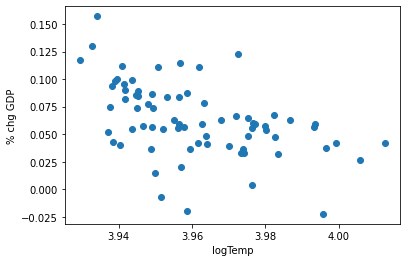

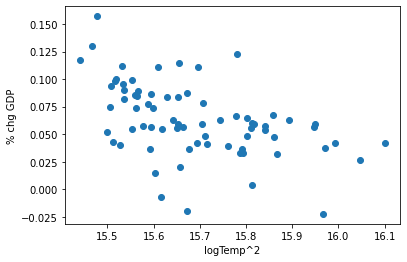

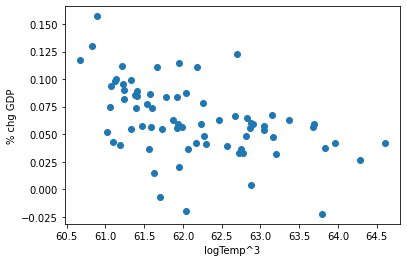

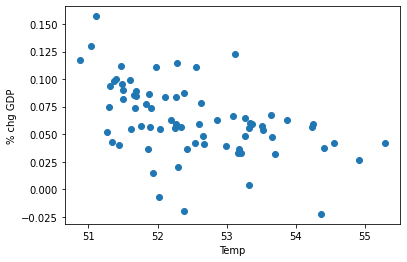

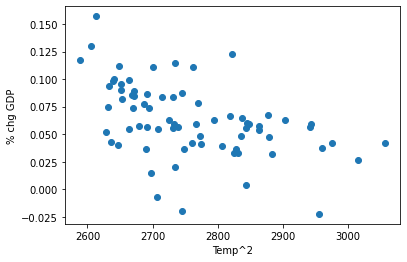

In [7]:
for i in range(5):
    plt.scatter(ind[var_list[i]]['1948':'2020'],dep['% chg GDP']['1948':'2020'])
    plt.xlabel(var_list[i])
    plt.ylabel('% chg GDP')
    plt.show()

### GDP on Precipitation

In [8]:
'''
Regress % change in GDP on all transformations of precipitation and display top 5 (one variable at a time)
'''

# Yearly Data
ind = build_independent_df('Precipitation', yearly=True)
summary = single_regression(dep,ind)
summary = summary.sort_values(by=['R_squared', 'p_value'], ascending=False)

display(summary.head())
columnNames = list(summary.head().index)
var_list = [i.split('_')[1] for i in columnNames]
print('Top variable:', var_list)

,R_squared,beta,p_value,RMSE
% chg GDP_$\Delta$Precipitation^3 lag1,0.0504,-0.1465,0.0562,0.0321
% chg GDP_Precipitation*($\Delta)$^3 lag1,0.0413,-0.0067,0.0846,0.0323
% chg GDP_ % changePrecipitation^3 lag1,0.0364,-1.3547,0.1057,0.0324
% chg GDP_$\Delta^2$Precipitation lag1,0.031,-0.0156,0.1361,0.0325
% chg GDP_Precipitation*($\Delta^2)$^2 lag2,0.0297,0.0044,0.1448,0.0325


Top variable: ['$\\Delta$Precipitation^3 lag1', 'Precipitation*($\\Delta)$^3 lag1', ' % changePrecipitation^3 lag1', '$\\Delta^2$Precipitation lag1', 'Precipitation*($\\Delta^2)$^2 lag2']


In [9]:
'''
Get the correlation among variables
'''

tempdf = ind[var_list]
corrdf = dep.join(tempdf)
corrdf.corr()

,% chg GDP,$\Delta$Precipitation^3 lag1,Precipitation*($\Delta)$^3 lag1,% changePrecipitation^3 lag1,$\Delta^2$Precipitation lag1,Precipitation*($\Delta^2)$^2 lag2
% chg GDP,1.0000,-0.2245,-0.2032,-0.1909,-0.1761,0.1724
$\Delta$Precipitation^3 lag1,-0.2245,1.0000,0.9706,0.9623,0.5908,-0.0856
Precipitation*($\Delta)$^3 lag1,-0.2032,0.9706,1.0000,0.9939,0.5194,-0.0675
% changePrecipitation^3 lag1,-0.1909,0.9623,0.9939,1.0000,0.4953,-0.0617
$\Delta^2$Precipitation lag1,-0.1761,0.5908,0.5194,0.4953,1.0000,-0.1027
Precipitation*($\Delta^2)$^2 lag2,0.1724,-0.0856,-0.0675,-0.0617,-0.1027,1.0000


In [10]:
ind = ind[ind.index != '1958']
dep = dep[dep.index != '1958']

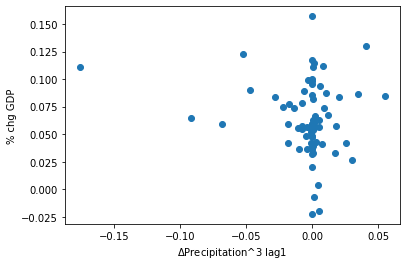

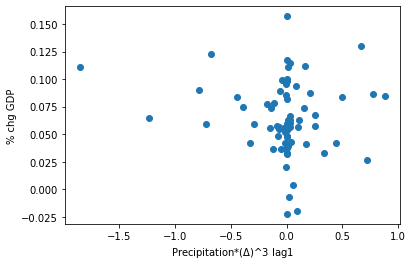

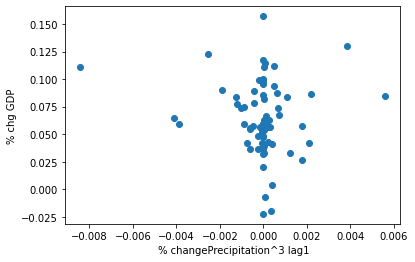

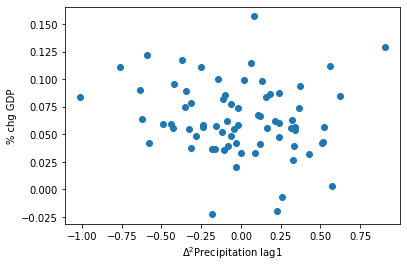

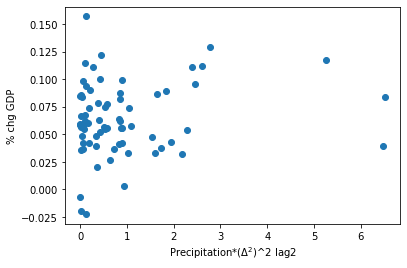

In [11]:
for i in range(5):
    
    plt.scatter(ind[var_list[i]]['1948':'2020'],dep['% chg GDP']['1948':'2020'])
    plt.xlabel(var_list[i])
    plt.ylabel('% chg GDP')
    plt.show()

### GDP on Sea level

In [12]:
'''
Sea Level Data requires some extra data-formatting to be consistent with other functions
'''

# Yearly Data
df = pd.read_excel('Sea Level.xls').iloc[:, 0:2].set_index('Date')
df.columns = ['Value']
variable = 'Sea Level'
df = df.rename(columns={"Value": 'Sea Level'})

df_sqr = df**2
col_names = df.columns
for name in col_names:
    df_sqr = df_sqr.rename(columns={name:name+r'^2'})

df = pd.concat([df, df_sqr], axis = 1)

df_lag1 = df.shift()
col_names = df.columns
for name in col_names:
    df_lag1 = df_lag1.rename(columns={name:name+' lag1'})

df_lag2 = df.shift(2)
col_names = df.columns
for name in col_names:
    df_lag2 = df_lag2.rename(columns={name:name+' lag2'})

df = pd.concat([df,df_lag1,df_lag2], axis = 1)
#df['log Sea Level'] = np.log(df['Sea Level'])
df['exp Sea Level'] = np.exp(df['Sea Level'])

df.index = df.index.to_period('Y')

In [13]:
df

,Sea Level,Sea Level^2,Sea Level lag1,Sea Level^2 lag1,Sea Level lag2,Sea Level^2 lag2,exp Sea Level
Date,,,,,,,
1947,0.1220,1.4896e-02,NaN,NaN,NaN,NaN,1.1298
1948,0.1890,3.5712e-02,0.1220,1.4896e-02,NaN,NaN,1.2080
1949,-0.0512,2.6195e-03,0.1890,3.5712e-02,0.1220,1.4896e-02,0.9501
1950,0.0866,7.5020e-03,-0.0512,2.6195e-03,0.1890,3.5712e-02,1.0905
1951,0.3740,1.3989e-01,0.0866,7.5020e-03,-0.0512,2.6195e-03,1.4536
1952,-0.1024,1.0478e-02,0.3740,1.3989e-01,0.0866,7.5020e-03,0.9027
1953,0.1732,3.0008e-02,-0.1024,1.0478e-02,0.3740,1.3989e-01,1.1891
1954,-0.1142,1.3036e-02,0.1732,3.0008e-02,-0.1024,1.0478e-02,0.8921
1955,0.0354,1.2555e-03,-0.1142,1.3036e-02,0.1732,3.0008e-02,1.0361


In [14]:
# Yearly Data
ind = df
dep = build_dependent_df('GDP', yearly=True).loc[df.index]
summary = single_regression(dep,ind)
summary = summary.sort_values(by=['R_squared', 'p_value'], ascending=False)

display(summary.head())
columnNames = list(summary.head().index)
var_list = [i.split('_')[1] for i in columnNames]
print('Top variable:', var_list)

,R_squared,beta,p_value,RMSE
% chg GDP_Sea Level^2,0.0777,0.1456,0.0177,0.0304
% chg GDP_Sea Level^2 lag2,0.0352,0.0972,0.1172,0.0310
% chg GDP_Sea Level lag1,0.0181,-0.023,0.2594,0.0313
% chg GDP_exp Sea Level,0.0107,0.0157,0.3882,0.0314
% chg GDP_Sea Level lag2,0.0059,-0.013,0.5242,0.0315


Top variable: ['Sea Level^2', 'Sea Level^2 lag2', 'Sea Level lag1', 'exp Sea Level', 'Sea Level lag2']


In [15]:
df

,Sea Level,Sea Level^2,Sea Level lag1,Sea Level^2 lag1,Sea Level lag2,Sea Level^2 lag2,exp Sea Level
Date,,,,,,,
1947,0.1220,1.4896e-02,NaN,NaN,NaN,NaN,1.1298
1948,0.1890,3.5712e-02,0.1220,1.4896e-02,NaN,NaN,1.2080
1949,-0.0512,2.6195e-03,0.1890,3.5712e-02,0.1220,1.4896e-02,0.9501
1950,0.0866,7.5020e-03,-0.0512,2.6195e-03,0.1890,3.5712e-02,1.0905
1951,0.3740,1.3989e-01,0.0866,7.5020e-03,-0.0512,2.6195e-03,1.4536
1952,-0.1024,1.0478e-02,0.3740,1.3989e-01,0.0866,7.5020e-03,0.9027
1953,0.1732,3.0008e-02,-0.1024,1.0478e-02,0.3740,1.3989e-01,1.1891
1954,-0.1142,1.3036e-02,0.1732,3.0008e-02,-0.1024,1.0478e-02,0.8921
1955,0.0354,1.2555e-03,-0.1142,1.3036e-02,0.1732,3.0008e-02,1.0361


In [16]:
'''
Get the correlation among variables
'''

tempdf = ind[var_list]
corrdf = dep.join(tempdf)
corrdf.corr()

,% chg GDP,Sea Level^2,Sea Level^2 lag2,Sea Level lag1,exp Sea Level,Sea Level lag2
% chg GDP,1.0000,0.2788,0.1876,-0.1347,0.1032,-0.0768
Sea Level^2,0.2788,1.0000,-0.0101,-0.2661,0.6410,-0.0437
Sea Level^2 lag2,0.1876,-0.0101,1.0000,-0.2149,-0.0824,0.5323
Sea Level lag1,-0.1347,-0.2661,-0.2149,1.0000,-0.3486,-0.3449
exp Sea Level,0.1032,0.6410,-0.0824,-0.3486,1.0000,0.0355
Sea Level lag2,-0.0768,-0.0437,0.5323,-0.3449,0.0355,1.0000


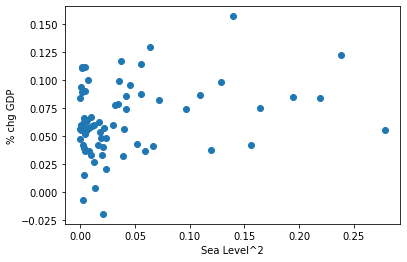

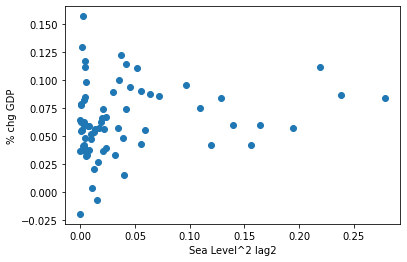

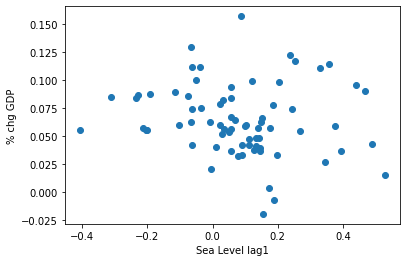

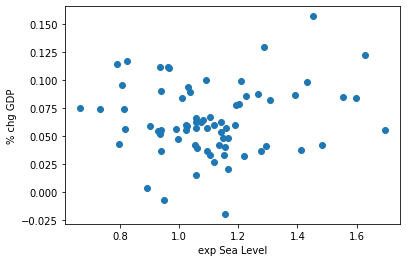

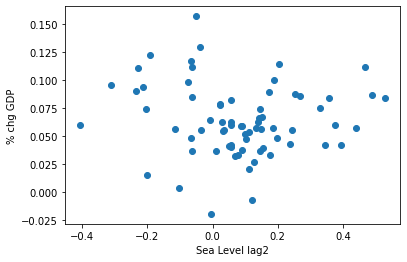

In [17]:
for i in range(5):
    plt.scatter(ind[var_list[i]]['1948':'2020'],dep['% chg GDP']['1948':'2020'])
    plt.xlabel(var_list[i])
    plt.ylabel('% chg GDP')
    plt.show()

## Multi - Regression Model

In [18]:
Sea = ind['Sea Level^2']
dep = build_dependent_df('GDP', yearly=True)
ind = build_independent_df('Precipitation', yearly=True)
Precip = pd.DataFrame(ind['Precipitation'+r'*($\Delta)$' + '^3 lag1'])
ind = build_independent_df('Temp', yearly=True)
############## using log temp and exp temp ################
Temp = ind[['logTemp','expTemp']]
data = pd.concat([dep, Temp ,Precip, Sea], axis = 1).dropna().reset_index()
data.columns = ['Date', 'GDP_pct_change', 'logTemp', 'expTemp', 'Precip*Change_3_lag1', 'SeaLevelChangeSq']

In [19]:
'''
Run the multi regression on each subsets of the set, print out the statistics values including beta values,
R_Squared, Adjusted R_Squared, and AIC score, and plot the scatter plot of actual value on predicted value.
'''

def multi_regression(independent, dependent): 
    summary = pd.DataFrame()
    independent_w_constant = sm.add_constant(independent)
    res = sm.OLS(dependent, independent_w_constant, missing='drop').fit()
    r_squared = round(res.rsquared, 4)
    adj_r_squared = round(res.rsquared_adj, 4)
    summary = pd.DataFrame(res.params[1:], columns = dependent.columns)
    summary.loc['R_squared'] = r_squared
    summary.loc['adj_R_suqared'] = adj_r_squared
    summary.loc['AIC'] = res.aic
    cols = ['VIF_'] + independent.columns
    
    
    if len(independent.columns) > 1:
        for i in range(len(independent.columns)):
            summary.loc['VIF_' + independent.columns[i]] = variance_inflation_factor(independent.values, i)

        display(independent.corr())
        
    plt.scatter(dependent, res.predict(independent_w_constant))
    plt.xlabel('Prediction')
    plt.ylabel('Actual Value')
    plt.show()
    
    
    return summary

In [35]:
independent = data.loc[:,['logTemp', 'expTemp', 'Precip*Change_3_lag1', 'SeaLevelChangeSq']]

In [36]:
dependent = data.loc[:, ['GDP_pct_change']]

In [37]:
independent_w_constant = sm.add_constant(independent)

In [38]:
res = sm.OLS(dependent, independent_w_constant, missing='drop').fit()

In [41]:
r_squared = res.rsquared
adj_r_squared = res.rsquared_adj
summary = pd.DataFrame(res.params[1:], columns = dependent.columns)
summary

,GDP_pct_change
logTemp,0.0000e+00
expTemp,1.4702e-25
Precip*Change_3_lag1,1.1497e-49
SeaLevelChangeSq,5.5209e-50


In [ ]:
res.

In [44]:
summary.loc['R_squared'] = r_squared
summary.loc['adj_R_suqared'] = adj_r_squared
summary.loc['AIC'] = res.aic
cols = ['VIF_'] + independent.columns
summary    

,GDP_pct_change
logTemp,0.0000e+00
expTemp,1.4702e-25
Precip*Change_3_lag1,1.1497e-49
SeaLevelChangeSq,5.5209e-50
R_squared,-3.2959e+00
adj_R_suqared,-3.2959e+00
AIC,-1.8613e+02


In [26]:
multi_regression(data.loc[:,['logTemp', 'expTemp', 'Precip*Change_3_lag1', 'SeaLevelChangeSq']], data.loc[:, ['GDP_pct_change'])

SyntaxError: closing parenthesis ')' does not match opening parenthesis '[' (110125726.py, line 1)

GDP_pct_change on ['logTemp']


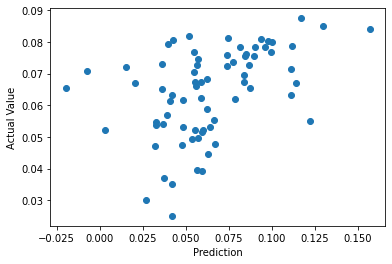

,GDP_pct_change
logTemp,-0.7539
R_squared,0.1996
adj_R_suqared,0.1882
AIC,-305.1103



GDP_pct_change on ['expTemp']


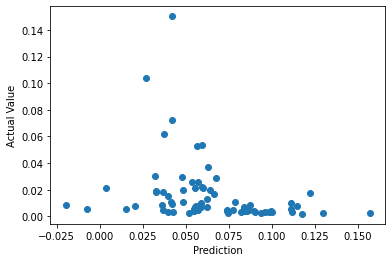

,GDP_pct_change
expTemp,1.4702e-25
R_squared,-3.2959e+00
adj_R_suqared,-3.2959e+00
AIC,-1.8613e+02



GDP_pct_change on ['Precip*Change_3_lag1']


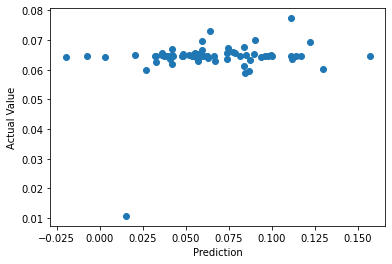

,GDP_pct_change
Precip*Change_3_lag1,-0.0068
R_squared,0.0469
adj_R_suqared,0.0333
AIC,-292.5393



GDP_pct_change on ['SeaLevelChangeSq']


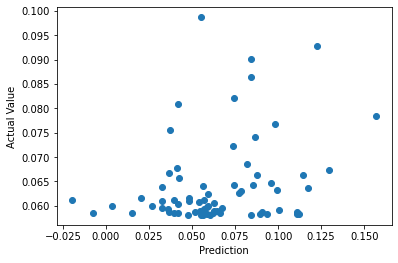

,GDP_pct_change
SeaLevelChangeSq,0.1456
R_squared,0.0777
adj_R_suqared,0.0645
AIC,-294.9019



GDP_pct_change on ['logTemp', 'expTemp']


,logTemp,expTemp
logTemp,1.0000,0.8241
expTemp,0.8241,1.0000


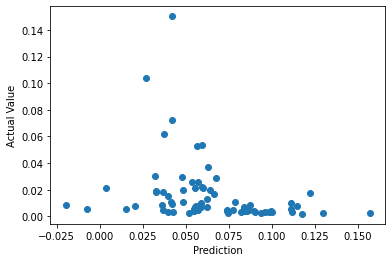

,GDP_pct_change
logTemp,0.0000e+00
expTemp,1.4702e-25
R_squared,-3.2959e+00
adj_R_suqared,-3.2959e+00
AIC,-1.8613e+02
VIF_logTemp,3.3159e-05
VIF_expTemp,1.4819e+00



GDP_pct_change on ['logTemp', 'Precip*Change_3_lag1']


,logTemp,Precip*Change_3_lag1
logTemp,1.0000,-0.0839
Precip*Change_3_lag1,-0.0839,1.0000


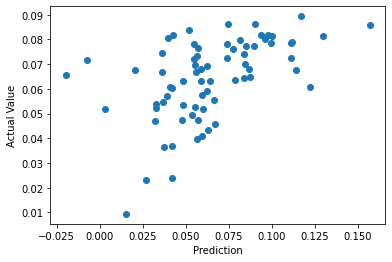

,GDP_pct_change
logTemp,-0.7902
Precip*Change_3_lag1,-0.0080
R_squared,0.2647
adj_R_suqared,0.2434
AIC,-309.2137
VIF_logTemp,1.0074
VIF_Precip*Change_3_lag1,1.0074



GDP_pct_change on ['logTemp', 'SeaLevelChangeSq']


,logTemp,SeaLevelChangeSq
logTemp,1.0000,-0.1199
SeaLevelChangeSq,-0.1199,1.0000


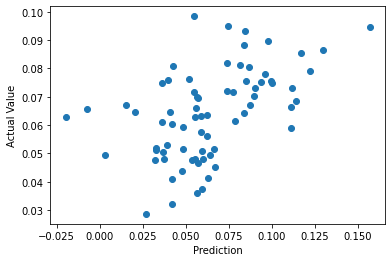

,GDP_pct_change
logTemp,-0.7077
SeaLevelChangeSq,0.1193
R_squared,0.2511
adj_R_suqared,0.2294
AIC,-307.8940
VIF_logTemp,1.4748
VIF_SeaLevelChangeSq,1.4748



GDP_pct_change on ['expTemp', 'Precip*Change_3_lag1']


,expTemp,Precip*Change_3_lag1
expTemp,1.0000,-0.0372
Precip*Change_3_lag1,-0.0372,1.0000


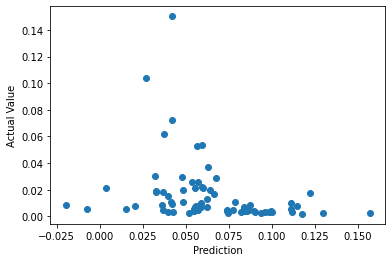

,GDP_pct_change
expTemp,1.4702e-25
Precip*Change_3_lag1,1.3782e-50
R_squared,-3.2959e+00
adj_R_suqared,-3.2959e+00
AIC,-1.8613e+02
VIF_expTemp,1.0003e+00
VIF_Precip*Change_3_lag1,9.9296e-01



GDP_pct_change on ['expTemp', 'SeaLevelChangeSq']


,expTemp,SeaLevelChangeSq
expTemp,1.000,0.042
SeaLevelChangeSq,0.042,1.000


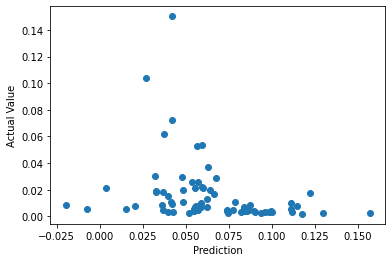

,GDP_pct_change
expTemp,1.4702e-25
SeaLevelChangeSq,5.5209e-50
R_squared,-3.2959e+00
adj_R_suqared,-3.2959e+00
AIC,-1.8613e+02
VIF_expTemp,1.1401e+00
VIF_SeaLevelChangeSq,7.7243e-01



GDP_pct_change on ['Precip*Change_3_lag1', 'SeaLevelChangeSq']


,Precip*Change_3_lag1,SeaLevelChangeSq
Precip*Change_3_lag1,1.0000,-0.0205
SeaLevelChangeSq,-0.0205,1.0000


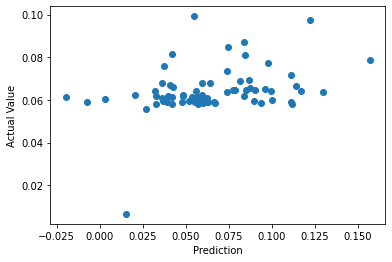

,GDP_pct_change
Precip*Change_3_lag1,-0.0066
SeaLevelChangeSq,0.1433
R_squared,0.1222
adj_R_suqared,0.0968
AIC,-296.4635
VIF_Precip*Change_3_lag1,1.0010
VIF_SeaLevelChangeSq,1.0010



GDP_pct_change on ['logTemp', 'expTemp', 'Precip*Change_3_lag1']


,logTemp,expTemp,Precip*Change_3_lag1
logTemp,1.0000,0.8241,-0.0839
expTemp,0.8241,1.0000,-0.0372
Precip*Change_3_lag1,-0.0839,-0.0372,1.0000


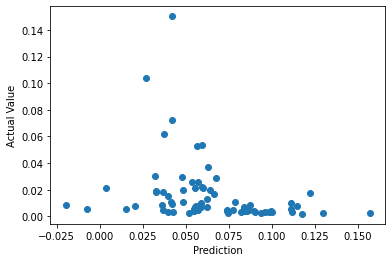

,GDP_pct_change
logTemp,0.0000e+00
expTemp,1.4702e-25
Precip*Change_3_lag1,1.3782e-50
R_squared,-3.2959e+00
adj_R_suqared,-3.2959e+00
AIC,-1.8613e+02
VIF_logTemp,3.3159e-05
VIF_expTemp,1.4840e+00
VIF_Precip*Change_3_lag1,9.9296e-01



GDP_pct_change on ['logTemp', 'expTemp', 'SeaLevelChangeSq']


,logTemp,expTemp,SeaLevelChangeSq
logTemp,1.0000,0.8241,-0.1199
expTemp,0.8241,1.0000,0.0420
SeaLevelChangeSq,-0.1199,0.0420,1.0000


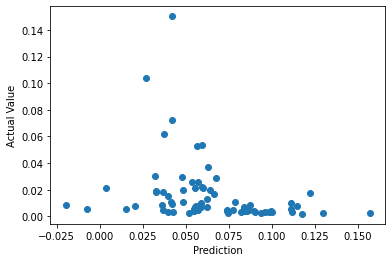

,GDP_pct_change
logTemp,0.0000e+00
expTemp,1.4702e-25
SeaLevelChangeSq,5.5209e-50
R_squared,-3.2959e+00
adj_R_suqared,-3.2959e+00
AIC,-1.8613e+02
VIF_logTemp,3.3159e-05
VIF_expTemp,1.4843e+00
VIF_SeaLevelChangeSq,7.7243e-01



GDP_pct_change on ['logTemp', 'Precip*Change_3_lag1', 'SeaLevelChangeSq']


,logTemp,Precip*Change_3_lag1,SeaLevelChangeSq
logTemp,1.0000,-0.0839,-0.1199
Precip*Change_3_lag1,-0.0839,1.0000,-0.0205
SeaLevelChangeSq,-0.1199,-0.0205,1.0000


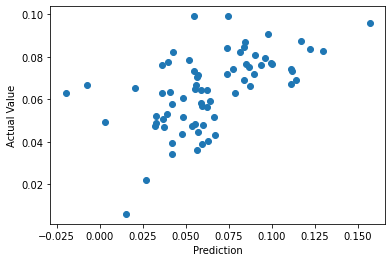

,GDP_pct_change
logTemp,-0.7446
Precip*Change_3_lag1,-0.0078
SeaLevelChangeSq,0.1153
R_squared,0.3127
adj_R_suqared,0.2823
AIC,-312.0720
VIF_logTemp,1.4847
VIF_Precip*Change_3_lag1,1.0078
VIF_SeaLevelChangeSq,1.4754



GDP_pct_change on ['expTemp', 'Precip*Change_3_lag1', 'SeaLevelChangeSq']


,expTemp,Precip*Change_3_lag1,SeaLevelChangeSq
expTemp,1.0000,-0.0372,0.0420
Precip*Change_3_lag1,-0.0372,1.0000,-0.0205
SeaLevelChangeSq,0.0420,-0.0205,1.0000


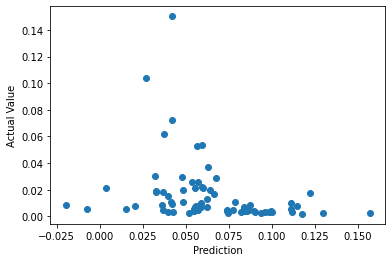

,GDP_pct_change
expTemp,1.4702e-25
Precip*Change_3_lag1,1.1497e-49
SeaLevelChangeSq,5.5209e-50
R_squared,-3.2959e+00
adj_R_suqared,-3.2959e+00
AIC,-1.8613e+02
VIF_expTemp,1.1401e+00
VIF_Precip*Change_3_lag1,9.9296e-01
VIF_SeaLevelChangeSq,7.7243e-01



GDP_pct_change on ['logTemp', 'expTemp', 'Precip*Change_3_lag1', 'SeaLevelChangeSq']


,logTemp,expTemp,Precip*Change_3_lag1,SeaLevelChangeSq
logTemp,1.0000,0.8241,-0.0839,-0.1199
expTemp,0.8241,1.0000,-0.0372,0.0420
Precip*Change_3_lag1,-0.0839,-0.0372,1.0000,-0.0205
SeaLevelChangeSq,-0.1199,0.0420,-0.0205,1.0000


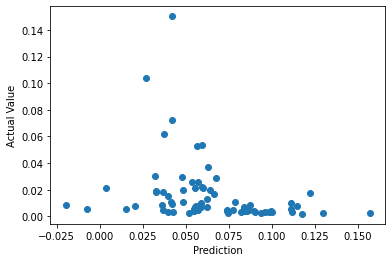

,GDP_pct_change
logTemp,0.0000e+00
expTemp,1.4702e-25
Precip*Change_3_lag1,1.1497e-49
SeaLevelChangeSq,5.5209e-50
R_squared,-3.2959e+00
adj_R_suqared,-3.2959e+00
AIC,-1.8613e+02
VIF_logTemp,3.3159e-05
VIF_expTemp,1.4863e+00
VIF_Precip*Change_3_lag1,9.9296e-01


In [20]:
ind_list = ['logTemp', 'expTemp', 'Precip*Change_3_lag1', 'SeaLevelChangeSq']
for L in range(1, len(ind_list)+1):
    for subset in itertools.combinations(ind_list, L):
        ind_subset = list(subset)
        print('GDP_pct_change on', ind_subset)
        display(multi_regression(data.loc[:, ind_subset], data.loc[:, ['GDP_pct_change']]))
        print()